# GR Shape detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Smoothing function

In [2]:
from smooth_functions import window_smooth

## Dataset

In [4]:
# Importing the dataset
dataset = pd.read_csv("Cheal-A8.csv")

# Filtering out null values
dataset = dataset.loc[dataset.GR >= 0]
dataset = dataset.loc[dataset.TVD >= 0]

# Selecting gr, tvd
gr = dataset.loc[:, "GR"].values
tvd = dataset.loc[:, "TVD"].values
md = dataset.loc[:, "Depth"].values

## Smoothing GR curve

### Smoothing

In [5]:
window_len = 16
gr_smooth = window_smooth(gr, window_len = window_len)
gr_smooth = gr_smooth[window_len // 2: window_len // 2 + len(gr)]

### Visualing GR smooth

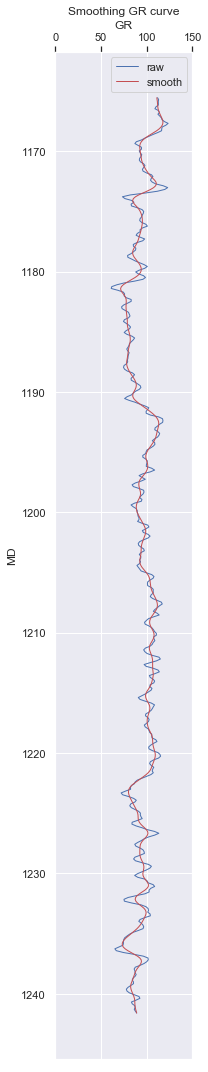

In [33]:
n_demo_samples = 500
demo_start = 5750
md_demo = md[demo_start: demo_start + n_demo_samples]
gr_demo = gr[demo_start: demo_start + n_demo_samples]
gr_smooth_demo = gr_smooth[demo_start: demo_start + n_demo_samples]

fig, ax = plt.subplots(figsize = (3, 15))
ax.plot(gr_demo, md_demo, label = 'raw', c = 'b', linewidth = 1)
ax.plot(gr_smooth_demo, md_demo, label = 'smooth', c = 'r', linewidth = 1)

ax.set_xlabel('GR')
ax.set_ylabel('MD')
ax.set_title("Smoothing GR curve")
#ax.set_title("Raw data")
plt.xlim([0, 150])
ax.xaxis.set_label_position('top')
ax.legend()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Finding changing direction points

### Points detection function

In [6]:
def changing_direction_point_detection(gr, epsilon = 0.02, multiplier = 2):
    diff = np.diff(gr, axis = 0)
    n_diff = len(diff)
    n_samples = n_diff + 1
    point_flags = np.zeros(n_samples)
    
    increase = False
    if diff[0] >= 0:
        increase = True
    
    for i in range (1, n_diff):
        if diff[i] * diff[i - 1] < 0:
            if abs(diff[i]) > epsilon or abs(diff[i - 1]) > epsilon:
                point_flags[i] = 1
        elif diff[i] * diff[i - 1] > 0:
            if abs(diff[i]) > abs(diff[i - 1]) * multiplier:
                point_flags[i] = 1
            elif abs(diff[i]) < abs(diff[i - 1]) / multiplier:
                point_flags[i] = 1
        elif diff[i] * diff[i - 1] == 0:
            if increase and diff[i] < 0:
                if abs(diff[i]) > 0:
                    point_flags[i] = 1
                    increase = not increase
            elif (not increase) and diff[i] > 0:
                if abs(diff[i]) > 0:
                    point_flags[i] = 1
                    increase = not increase
    return point_flags

### Detecting changing direction points

In [12]:
epsilon = 0.07
multiplier = 5
change_direction_point_flag = changing_direction_point_detection(gr_smooth, epsilon, multiplier)

### Visualising changing direction points

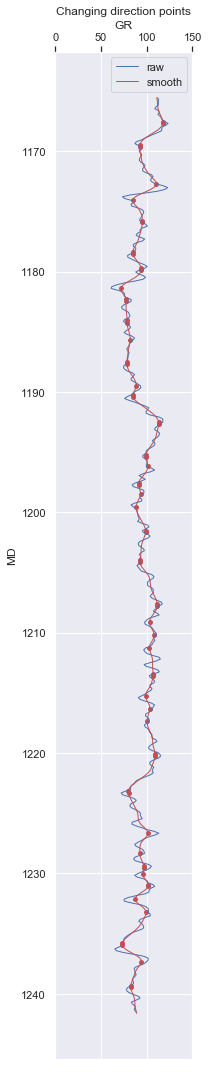

In [14]:
n_demo_samples = 500
demo_start = 5750
md_demo = md[demo_start: demo_start + n_demo_samples]
gr_demo = gr[demo_start: demo_start + n_demo_samples]
gr_smooth_demo = gr_smooth[demo_start: demo_start + n_demo_samples]
change_direction_point_flag_demo = change_direction_point_flag[demo_start: demo_start + n_demo_samples]

fig, ax = plt.subplots(figsize = (3, 15))
ax.plot(gr_demo, md_demo, label = 'raw', c = 'b', linewidth = 1)
ax.plot(gr_smooth_demo, md_demo, label = 'smooth', c = 'r', linewidth = 1)
ax.scatter(gr_smooth_demo[change_direction_point_flag_demo == 1],
            md_demo[change_direction_point_flag_demo == 1],
            s = 15, c = 'r')
ax.set_xlabel('GR')
ax.set_ylabel('MD')
ax.set_title("Changing direction points")
#ax.set_title("Raw data")
plt.xlim([0, 150])
ax.xaxis.set_label_position('top')
ax.legend()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Boundary selection

### Boundary selection function

In [17]:
def boundary_selection(point_flag, depth, gr, gr_theshold):
    n_samples = point_flag.shape[0]
    selection_point_flag = point_flag.copy()
    left = 0
    for i in range (1, n_samples):
        if selection_point_flag[i]:
            if depth[i] - depth[left] <= 1:
                delta_gr = gr[i] - gr[left]
                if abs(delta_gr) > gr_theshold:
                    selection_point_flag[left] = 0
                    selection_point_flag[i] = 0
                    left = (left + i) // 2
                    selection_point_flag[left] = 1
                else:
                    selection_point_flag[i] = 0
            else:
                left = i
    return selection_point_flag

### Boundary selection

In [23]:
gr_threshold = 10
point_flag = boundary_selection(change_direction_point_flag, tvd, gr, gr_threshold)

# Last point should be a boundary
point_flag[-1] = 1

### Visualising unit

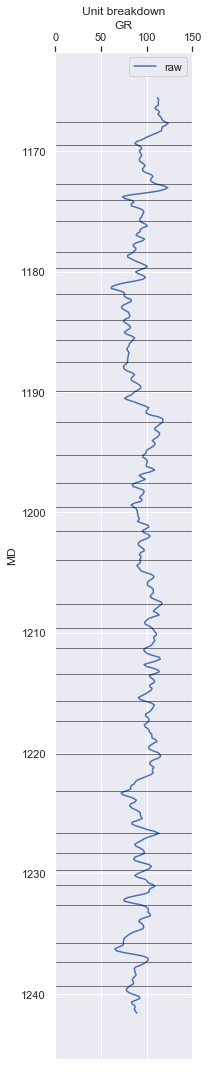

In [20]:
n_demo_samples = 500
demo_start = 5750

md_demo = md[demo_start: demo_start + n_demo_samples]
gr_demo = gr[demo_start: demo_start + n_demo_samples]

point_flag_demo = point_flag[demo_start: demo_start + n_demo_samples]

fig, ax = plt.subplots(figsize = (3, 15))
ax.plot(gr_demo, md_demo, label = 'raw', c = 'b', linewidth = 1.5)

for y in (md_demo[point_flag_demo == 1]):
    ax.axhline(y, c = 'black', linewidth = 0.5)
ax.set_xlabel('GR')
ax.set_ylabel('MD')
ax.set_title("Unit breakdown")
#ax.set_title("Raw data")
plt.xlim([0, 150])
ax.xaxis.set_label_position('top')
ax.legend()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Labling GR shape

### Labing shape function

In [24]:
def shape_label(gr, tvd, boudary_point, gr_threshold, tvd_threshold):
    n_samples = gr.shape[0]
    label = np.zeros(n_samples).astype(np.int8)
    gr_set = []
    idx_set = []
    for i in range (n_samples):
        gr_set.append(gr[i])
        idx_set.append(i)
        if boudary_point[i] or i == n_samples - 1:
            gr_set = np.array(gr_set)
            avg_first = np.average(gr_set[:2])
            avg_last = np.average(gr_set[-2:])
            delta = gr_set[0] - gr_set[-1]
            delta_avg = avg_first - avg_last
            if (tvd[idx_set[-1]] - tvd[idx_set[0]] <= tvd_threshold):
                if max(abs(delta), abs(delta_avg)) <= gr_threshold:
                    label[idx_set] = 2
                elif max(delta, delta_avg) > gr_threshold:
                    label[idx_set] = 1
                elif min(delta, delta_avg) < -gr_threshold:
                    label[idx_set] = 4
            else:
                if (gr_set.shape[0] > 10):
                    if max(abs(delta), abs(delta_avg)) <= gr_threshold:
                        label[idx_set] = 2
                    elif max(delta, delta_avg) > gr_threshold:
                        label[idx_set] = 1
                    elif min(delta, delta_avg) < -gr_threshold:
                        label[idx_set] = 4
                else:
                    label[idx_set] = 0

            idx_set = []
            gr_set = []
    return label

### Refining function

In [28]:
def compute_rate_of_change(arr):
    n_samples = arr.shape[0]
    avg_first = np.average(arr[:2])
    avg_last = np.average(arr[-2:])
    base_line = np.linspace(avg_first, avg_last, n_samples, endpoint = True)
    difference = (arr - base_line)
#    count = ((difference[:-1] * difference[1:]) < 0).sum()
    upward = True
    count = 0
    i = 0
    while difference[i] == 0 and i < n_samples:
        i += 1
    if difference[i] < 0 and i < n_samples:
        upward = False
    for j in range (i + 1, n_samples):
        if (upward and difference[j] < 0) or ((not upward) and difference[j] > 0):
            count += 1
            upward = not upward
    return count / n_samples

def refining_label(labels, gr, tvd, gr_threshold, tvd_threshold, roc_threshold):
    n_samples = labels.shape[0]
    refined_labels = labels.copy()
    un_flag = 0
    gr_set = []
    idx_set = []
    
    for i in range(n_samples):
        if un_flag:
            if labels[i] == 2:
                gr_set.append(gr[i])
                idx_set.append(i)
            else:
                gr_set = np.array(gr_set)
                avg_first = np.average(gr_set[:2])
                avg_last = np.average(gr_set[-2:])
                delta = gr_set[0] - gr_set[-1]
                delta_avg = avg_first - avg_last
                if (tvd[idx_set[-1]] - tvd[idx_set[0]] <= tvd_threshold):
                    if max(abs(delta), abs(delta_avg)) <= gr_threshold:
                        refined_labels[idx_set] = 2
                    elif max(delta, delta_avg) > gr_threshold:
                        refined_labels[idx_set] = 1
                    elif min(delta, delta_avg) < -gr_threshold:
                        refined_labels[idx_set] = 4
                else:
                    if compute_rate_of_change(gr_set) > roc_threshold:
                        refined_labels[idx_set] = 3
                    else:
                        if max(abs(delta), abs(delta_avg)) <= gr_threshold:
                            refined_labels[idx_set] = 2
                        elif max(delta, delta_avg) > gr_threshold:
                            refined_labels[idx_set] = 1
                        elif min(delta, delta_avg) < -gr_threshold:
                            refined_labels[idx_set] = 4
                un_flag = 0
                gr_set = []
                idx_set = []
        else:
            if labels[i] == 2:
                un_flag = 1
                gr_set.append(gr[i])
                idx_set.append(i)        
    return refined_labels

### Labling shape

In [26]:
gr_threshold = 10
tvd_threshold = 2
labels = shape_label(gr, tvd, point_flag, gr_threshold, tvd_threshold)

### Refining shape

In [29]:
gr_threshold = 10
tvd_threshold = 2
roc_threshold = 0.3

refined_labels = refining_label(labels, gr, tvd, gr_threshold, tvd_threshold, roc_threshold)

### Visualising unit shape

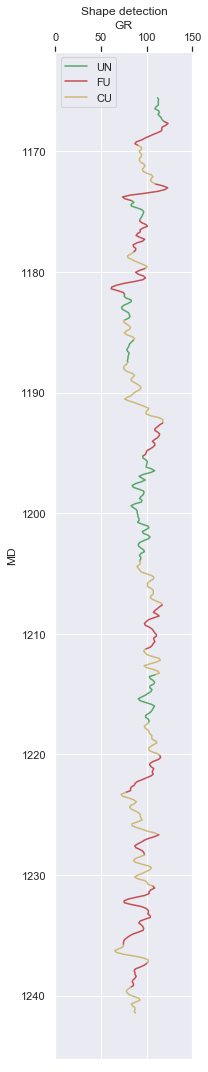

In [31]:
n_demo_samples = 500
demo_start = 5750

md_demo = md[demo_start: demo_start + n_demo_samples]
gr_demo = gr[demo_start: demo_start + n_demo_samples]

point_flag_demo = point_flag[demo_start: demo_start + n_demo_samples]
labels_demo = refined_labels[demo_start: demo_start + n_demo_samples]

colors = ['c', 'r', 'g', 'b', 'y']
str_labels = ['', 'FU', 'UN', 'SR', 'CU']

fig, ax = plt.subplots(figsize = (3, 15))

idx_set = [0]
for i in range (1, n_demo_samples):
    if labels_demo[i - 1] != labels_demo[i] or i == n_demo_samples - 1:
        label = labels_demo[i - 1]
        str_label = str_labels[label]
        if str_label in plt.gca().get_legend_handles_labels()[1]:
            str_label = ''
        ax.plot(gr_demo[idx_set], md_demo[idx_set], c = colors[label], label = str_label, linewidth = 1.5)
        idx_set = [i - 1]
    idx_set.append(i)

ax.set_xlim([0, 150])
ax.set_xlabel('GR')
ax.set_ylabel('MD')
ax.legend()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.invert_yaxis()
plt.title('Shape detection')
plt.tight_layout()
plt.show()

## Computing Thickness

In [34]:
idx_set = [0]
n_samples = gr.shape[0]
tvd_diff = np.zeros(n_samples)

for i in range (1, n_samples):
    if point_flag[i] == 0 and point_flag[i - 1] == 1:
        tvd_diff[idx_set] = tvd[idx_set[-1]] - tvd[idx_set[0]]
        idx_set = []
    idx_set.append(i)
    if i == n_samples - 1:
        tvd_diff[idx_set] = tvd[idx_set[-1]] - tvd[idx_set[0]]

In [37]:
new_dataset = np.array(dataset)

new_dataset = np.append(new_dataset, gr_smooth.reshape(-1, 1), axis = 1)
new_dataset = np.append(new_dataset, point_flag.reshape(-1, 1), axis = 1)
new_dataset = np.append(new_dataset, refined_labels.reshape(-1, 1), axis = 1)
new_dataset = np.append(new_dataset, tvd_diff.reshape(-1, 1), axis = 1)

columns = ['DEPTH', 'BS', 'CALI', 'DENS', 'DTC', 'GR', 'NEUT', 'PEF', 'RESD', 'RESM', 'RESS',
           'SP', 'TEMP', 'TENS', 'TVD', 'V_mud',
           'GR_smooth', 'Unit_mark_final', 'GR_SHAPE', 'Thickness']

df = pd.DataFrame(new_dataset, columns = columns)

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def transform_X(X):
	X = np.copy(X)
	X[:,-1] = X[:,-1].astype(np.int32)
	X[:,-2] = X[:,-2].astype(np.int32)
	litho = X[:,-1]
	if 4 in litho:
		X[:,-1][litho == 4] = 3

	litho_enc = OneHotEncoder(sparse=False, categories=[[1,2,3]])
	shape_enc = OneHotEncoder(sparse=False, categories=[[1,2,3,4]])
	ct = ColumnTransformer([('litho', litho_enc, [-1]),
							('gr_shape', shape_enc, [-2])],
						   remainder='passthrough',
						   sparse_threshold=0)
	X = ct.fit_transform(X)

	return X

def predict(model, X):
	X = np.copy(X)
	litho = X[:,-1]
	X = transform_X(X)

	pred = model.predict(X)

	if 4 in litho:
		pred[litho == 4] = 5

	return pred

In [39]:
df['Lithofacies'] = -999

bottom = [np.min(df['TVD'])-0.01] + df['TVD'][df['Unit_mark_final'] == 1].values.tolist()

for i in range(len(bottom)-1, 0, -1):
	mask = (df['TVD'] <= bottom[i]) & (df['TVD'] > bottom[i-1])
	tmp = df[mask]['TVD'].values
	vmud = df['V_mud'][mask].values

	litho = np.zeros(5)
	litho[1] = np.count_nonzero(vmud < 0.15)
	litho[2] = np.count_nonzero((vmud >= 0.15) & (vmud < 0.5))
	litho[3] = np.count_nonzero((vmud >= 0.5) & (vmud < 0.7))
	litho[4] = np.count_nonzero(vmud >= 0.7)

	df.loc[mask, 'Lithofacies'] = np.argmax(litho)

test_df = df.copy()

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as Model
train_csv = 'CHEAL-1-Thickness2.csv'

features = ['GR', 'DTC', 'DENS', 'NEUT', 'Thickness', 'GR_SHAPE', 'Lithofacies']
target = ['Facies_code']

df = pd.read_csv(train_csv, header=0)[features + ['Facies_code']]
df = df[~((df['Lithofacies'] == 4) & (df['Facies_code'] != 5))]
df = df[~((df['Lithofacies'] != 4) & (df['Facies_code'] == 5))]
data = df[~df.isin(['-999', -999]).any(axis=1)]

X = data[features].values
y = data[target].values.astype(np.int32).flatten()

X_train, X_test, y_train, y_test = (
	train_test_split(X, y, stratify=X[:,-1], test_size=0.2, shuffle=True))

model = Model(
			  n_estimators=30,
			  criterion='entropy',
			  min_samples_split=3,
			  min_impurity_decrease=0.001,
			  class_weight='balanced')

mask = X_train[:,-1] != 4
model.fit(transform_X(X_train[mask,:]), y_train[mask])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.001,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [51]:
mark = test_df['Unit_mark_final'].values
data = test_df[features]

X = data.values
facies_code = predict(model, X)
start = 0

# from scipy import stats
# for i in range(len(pred)):
# 	if mark[i] == 1:
# 		tmp = pred[start:i+1]
# 		pred[start:i+1] = stats.mode(tmp)[0][0]
# 		start = i+1

In [52]:
n_samples = gr.shape[0]
unit_flag = 0
facies_set = []
idx_set = []
threshold = 3
refined_facies_code = facies_code.copy()

for i in range(0, n_samples):
    facies_set.append(facies_code[i])
    idx_set.append(i)
    if point_flag[i] == 1 or i == n_samples:
        depo_major = np.bincount(facies_set).argmax()
        refined_facies_code[idx_set] = depo_major
        idx_set = []
        facies_set = []

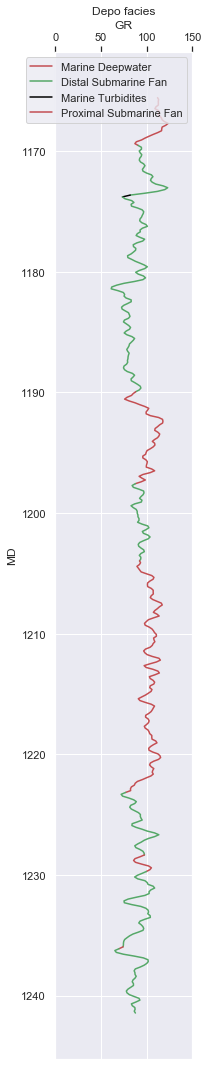

In [53]:
n_demo_samples = 500
demo_start = 5750

md_demo = md[demo_start: demo_start + n_demo_samples]
gr_demo = gr[demo_start: demo_start + n_demo_samples]

point_flag_demo = point_flag[demo_start: demo_start + n_demo_samples]
labels_demo = pred[demo_start: demo_start + n_demo_samples]

colors = ['c', 'r', 'g', 'black', 'y', 'r']
str_labels = ['', 'Proximal Submarine Fan', 'Distal Submarine Fan ', 'Marine Turbidites', 'Distal Marine turbidites', 'Marine Deepwater']

fig, ax = plt.subplots(figsize = (3, 15))

idx_set = [0]
for i in range (1, n_demo_samples):
    if labels_demo[i - 1] != labels_demo[i] or i == n_demo_samples - 1:
        label = labels_demo[i - 1]
        str_label = str_labels[label]
        if str_label in plt.gca().get_legend_handles_labels()[1]:
            str_label = ''
        ax.plot(gr_demo[idx_set], md_demo[idx_set], c = colors[label], label = str_label, linewidth = 1.5)
        idx_set = [i - 1]
    idx_set.append(i)

ax.set_xlim([0, 150])
ax.set_xlabel('GR')
ax.set_ylabel('MD')
ax.legend()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.invert_yaxis()
plt.title('Depo facies')
plt.tight_layout()
plt.show()